In [44]:
import os
import pandas as pd
import numpy as np
import gzip
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizerFast as BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [46]:
def read_folder(folder_path):
    dataframes = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jsonl.gz'):
            with gzip.open(os.path.join(folder_path, filename), 'rt', encoding='utf-8') as file:
                for line in file:
                    json_data = json.loads(line)
                    df = pd.DataFrame(json_data)
                    dataframes.append(df)
    if dataframes:
        aggregated_df = pd.concat(dataframes, ignore_index=True)
        return aggregated_df
    else:
        print("No jsonl files found in the directory.")
        return None
    
def reduce(_number=6):
    # csak a test
    test = os.path.join(os.getcwd(), 'test')
    df = read_folder(test)
    df.drop('uuid', axis=1, inplace=True)
    return df.groupby('major_topic_pred').apply(lambda x: x.sample(n=min(_number, len(x)))).reset_index(drop=True)


df_train = reduce()
df_test = reduce(3)
df_eval = reduce(3)

print(df_train.index)
print(df_test.index)
print(df_eval.index)

labels = df_train['major_topic_pred'].unique().tolist()
number_of_labels = len(labels)
id_to_label = {_id: label for _id, label in enumerate(labels)}
label_to_id = {label: _id for _id, label in enumerate(labels)}


df_train['major_topic_pred_index'] = df_train['major_topic_pred'].map(lambda x: label_to_id[x])
df_test['major_topic_pred_index'] = df_test['major_topic_pred'].map(lambda x: label_to_id[x])
df_eval['major_topic_pred_index'] = df_eval['major_topic_pred'].map(lambda x: label_to_id[x])

RangeIndex(start=0, stop=132, step=1)
RangeIndex(start=0, stop=66, step=1)
RangeIndex(start=0, stop=66, step=1)


In [47]:
df_train.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Alapos megütötték a bitcoint - Az amerikai tőz...,A hétvégi G7-csúcstalálkozó nagy adómegállapod...,2021. június 08. 22:45\n\nNem volt egységes ir...,portfolio.hu,https://www.portfolio.hu/uzlet/20210608/alapos...,2021-06-08T22:45:00,2021-06-15T04:20:35,"Nasdaq,",0.620573,1,0
1,Két számjegyû mértékben nõttek a keresetek Mag...,A teljes munkaidõben alkalmazásban állók átlag...,Az elsõ öt hónapban a bruttó és a nettó átlagk...,origo.hu,http://www.origo.hu/gazdasag/20180720-ksh-ket-...,2018-07-20T11:53:00,2018-10-20T21:50:52,foglalkoztatás,0.776381,1,0
2,Felére csökkent a Volkswagen nyeresége,A Volkswagen harmadik negyedéves nyeresége köz...,A gyár nettó profitja 439 millió euróra csökke...,origo.hu,https://www.origo.hu/gazdasag/hirek/20021030fe...,2002-10-30T11:07:00,2019-05-27T12:36:13,devizapiac,0.823234,1,0
3,Kedden kamatdöntő ülést tart az MNB,Jövő héten kamatdöntő ülést tart a Magyar Nemz...,Kamatdöntő ülést tart kedden a monetáris tanác...,index.hu,https://index.hu/gazdasag/2023/03/26/mnb-kamat...,2023-03-26T09:45:00,2023-05-28T12:26:13,ksh,0.584020,1,0
4,Városi terepjáróvá hizlalták az Év autóját - T...,Az új Cross pont annyival nagyobb a normál Yar...,"A Toyota a legkisebb szabadidő-autójából, a Ya...",origo.hu,https://www.origo.hu/auto/20210629-toyota-yari...,2021-06-30T20:02:00,2021-10-23T23:25:53,Toyota Yaris,0.643884,1,0


In [48]:
df_test.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Fejvesztve menekítik a magyarok a pénzüket az ...,A magas infláció miatt nagyon is érthető átren...,Számos érdekesség kirajzolódik az MNB előzetes...,portfolio.hu,https://www.portfolio.hu/befektetes/20230518/f...,2023-05-18T10:59:00,2023-05-31T00:22:17,"bankbetét,",0.682144,1,0
1,Friss kémfotókon a Ferrari első szabadidő-autója,Az összkerékhajtású hibrid Purosangue-ot előre...,Ha valaki igazán izgalmas olasz divatterepjáró...,hvg.hu,https://hvg.hu/cegauto/20210407_friss_kemfotok...,2021-04-07T06:41:00,2021-04-23T06:29:43,olasz,0.379798,1,0
2,Orbán ellentmondott Matolcsynak,Orbán Viktor szerint a gazdasági növekedéssel ...,Orbán Viktor miniszterelnök szerint a gazdaság...,origo.hu,https://www.origo.hu/gazdasag/20141031-orban-e...,2014-10-31T11:43:00,2019-08-26T02:13:49,költségvetés 2015,0.869738,1,0
3,Nem nézett rá a megtámadott cigány asszony a r...,Először találkozhattak a cigányok elleni támad...,A cigányok elleni támadássorozat első roma sér...,origo.hu,https://www.origo.hu/itthon/20110518-nem-nezet...,2011-05-18T11:10:00,2022-11-28T01:54:23,cigányok elleni támadások,0.647014,2,1
4,Nem nézett rá a megtámadott cigány asszony a r...,Először találkozhattak a cigányok elleni támad...,A cigányok elleni támadássorozat első roma sér...,origo.hu,https://www.origo.hu/itthon/20110518-nem-nezet...,2011-05-18T11:10:00,2022-11-28T01:54:23,romagyilkosság,0.647014,2,1


In [49]:
df_eval.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Felére csökkent a Volkswagen nyeresége,A Volkswagen harmadik negyedéves nyeresége köz...,A gyár nettó profitja 439 millió euróra csökke...,origo.hu,https://www.origo.hu/gazdasag/hirek/20021030fe...,2002-10-30T11:07:00,2019-05-27T12:36:13,adózás,0.823234,1,0
1,Orbán ellentmondott Matolcsynak,Orbán Viktor szerint a gazdasági növekedéssel ...,Orbán Viktor miniszterelnök szerint a gazdaság...,origo.hu,https://www.origo.hu/gazdasag/20141031-orban-e...,2014-10-31T11:43:00,2019-08-26T02:13:49,költségvetés 2015,0.869738,1,0
2,"Putyin elismerte, megszorítások jöhetnek","„Nem lehet válságról beszélni” Putyin szerint,...","„Nem hiszem, hogy válságról beszélhetünk” – mo...",origo.hu,https://www.origo.hu/gazdasag/20141218-putyin-...,2014-12-18T15:59:00,2020-09-30T04:13:35,Ukrajna,0.701693,1,0
3,Nem volt gyűlölet-bűncselekmény a terhes roma ...,A rendőrség szerint csak becsületsértés történ...,"Gyöngyöspatán, március elején fekete maszkos, ...",index.hu,https://index.hu/belfold/2011/06/01/nem_volt_g...,2011-06-01T12:56:00,2021-03-01T23:18:27,gyöngyöspata,0.766326,2,1
4,Néhány roma gyerek kiemelése csak ráerősít a r...,Lehet-e felnőttoktatással kárpótolni a gyerekk...,"Nincs hivatalos, mindenki által elfogadott kép...",24.hu,https://24.hu/belfold/2020/01/28/gyongyospata-...,2020-01-28T11:09:00,2021-05-10T02:07:58,Belföld,0.764033,2,1


In [50]:
id_to_label, label_to_id

({0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 12,
  11: 13,
  12: 14,
  13: 15,
  14: 16,
  15: 17,
  16: 18,
  17: 19,
  18: 20,
  19: 21,
  20: 23,
  21: 999},
 {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  12: 10,
  13: 11,
  14: 12,
  15: 13,
  16: 14,
  17: 15,
  18: 16,
  19: 17,
  20: 18,
  21: 19,
  23: 20,
  999: 21})

In [51]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, return_tensors='pt')

In [52]:
LABEL = 'major_topic_pred'
ARTICLE = 'article'

sample_row = df_train.iloc[0]
sample_article = sample_row[ARTICLE]
sample_label = sample_row[LABEL]

print(sample_article)
print("label: ", sample_label)

2021. június 08. 22:45

Nem volt egységes irány Amerikában

Eltérően teljesítettek a tengerentúli részvényindexek kedden: a Dow Jones érétke 0,1 százalékot csökkent, míg az S&P 500 (+0,02%) és a Nasdaq (+0,31%) értéke szerény mértékben emelkedett.

2021. június 08. 20:15

Szinte meg sem rezdül Amerika

Nem láthatunk éremi elmozdulásokat a tengerentúli részvényindexek esetében kedden, az S&P 500, a Dow Jones és a Nasdaq értéke is a tegnapi záróértékének közvetlen közelében tartózkodik.

A befektetők fantáziáját az sem mozgatta meg, hogy az import csökkenésének hatására mérséklődött az Egyesült Államok külkereskedelmi mérlegének hiánya áprilisban az előző hónapok rekordszintjei után, ami azt jelezheti, hogy a hazai kereslet kezd a szolgáltatások felé fordulni az áruk helyett.

2021. június 08. 09:37

Tovább esik a bitcoin

Tovább esik ma a bitcoin árfolyama, tegnapi eséssel együtt összesen két nap alatt 10 százalékkal került lejjebb a jegyzés, amivel még így is 13,8 százalékot emelkedett

In [53]:
encoding = tokenizer.encode_plus(
  sample_article,
  add_special_tokens=True,
  max_length=1024,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [54]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 2701]), torch.Size([1, 2701]))

In [55]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', '2021', '.', 'jun', '##ius', '08', '.', '22', ':', '45', 'ne', '##m', 'vol', '##t', 'e', '##gy', '##se', '##ges', 'iran', '##y']


In [56]:
token_counts = []

for _, row in df_train.iterrows():
    token_count = len(tokenizer.encode(
        row[ARTICLE], 
        max_length=512, 
        truncation=True
    ))
    token_counts.append(token_count)

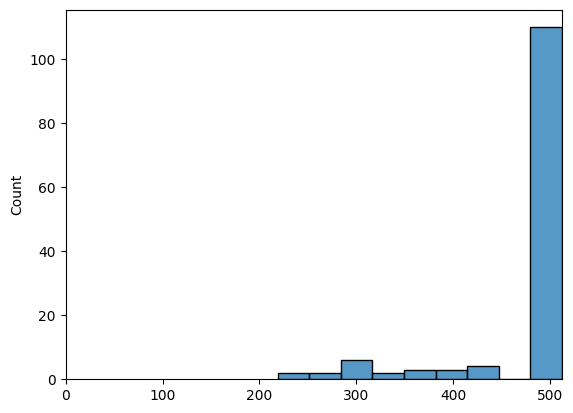

In [57]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [58]:
MAX_TOKEN_COUNT = 512

In [59]:
class ArticleDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame, 
        tokenizer: BertTokenizer, 
        max_token_len: int = 128
    ) -> None:
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        article = data_row[ARTICLE]
        label = data_row[LABEL]

        encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            article=article,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            label=torch.tensor(label, dtype=torch.long)
        )

In [60]:
train_dataset = ArticleDataset(
  df_train,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['article', 'input_ids', 'attention_mask', 'label'])

In [61]:
sample_item

{'article': '2021. június 08. 22:45\n\nNem volt egységes irány Amerikában\n\nEltérően teljesítettek a tengerentúli részvényindexek kedden: a Dow Jones érétke 0,1 százalékot csökkent, míg az S&P 500 (+0,02%) és a Nasdaq (+0,31%) értéke szerény mértékben emelkedett.\n\n2021. június 08. 20:15\n\nSzinte meg sem rezdül Amerika\n\nNem láthatunk éremi elmozdulásokat a tengerentúli részvényindexek esetében kedden, az S&P 500, a Dow Jones és a Nasdaq értéke is a tegnapi záróértékének közvetlen közelében tartózkodik.\n\nA befektetők fantáziáját az sem mozgatta meg, hogy az import csökkenésének hatására mérséklődött az Egyesült Államok külkereskedelmi mérlegének hiánya áprilisban az előző hónapok rekordszintjei után, ami azt jelezheti, hogy a hazai kereslet kezd a szolgáltatások felé fordulni az áruk helyett.\n\n2021. június 08. 09:37\n\nTovább esik a bitcoin\n\nTovább esik ma a bitcoin árfolyama, tegnapi eséssel együtt összesen két nap alatt 10 százalékkal került lejjebb a jegyzés, amivel még íg

In [62]:
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 10

def create_dataloader(df, tokenizer, max_token_len, batch_size):
    dataset = ArticleDataset(
        df,
        tokenizer=tokenizer,
        max_token_len=max_token_len
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4
    )

In [63]:
data_loader_train = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_test = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_eval = create_dataloader(df_eval, tokenizer, MAX_LEN, BATCH_SIZE)

In [64]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, return_dict=True)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 10
BATC_SIZE = 8

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in data_loader_train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        print("loss: " + loss)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'ArticleDataset' on <module '__main__' (built-in)>


In [ ]:
model.eval()
eval_loss = 0
correct_labels = 0

with torch.no_grad():
    for batch in data_loader_eval:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        correct_labels += (logits.argmax(1) == labels).sum().item()

/Users/I577305/Library/Python/3.11/lib/python/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KUKA

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels